# Unsupervised learning: grouping alike


In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA

## Data

In [2]:
db = pd.read_csv('data/analysis_ready.csv.gz')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53904 entries, 0 to 53903
Data columns (total 20 columns):
review_scores_rating           36642 non-null float64
review_scores_accuracy         36529 non-null float64
review_scores_cleanliness      36562 non-null float64
review_scores_checkin          36474 non-null float64
review_scores_communication    36560 non-null float64
review_scores_location         36487 non-null float64
review_scores_value            36477 non-null float64
id                             53904 non-null int64
last_scraped                   53904 non-null object
last_review                    37438 non-null object
neighbourhood_cleansed         53904 non-null object
longitude                      53904 non-null float64
latitude                       53904 non-null float64
room_type                      53904 non-null object
property_type                  53904 non-null object
bathrooms                      53644 non-null float64
bedrooms                       538

In [3]:
cont = ['bathrooms', 'bedrooms', 'beds', 'price_cleansed']

In [4]:
features = db[cont].dropna()

To note:

- List of continuous variables
- Convert room and property type into numerical values
- Pack all features into a table (why does the `join` not complain?)
- Drop rows with missing values

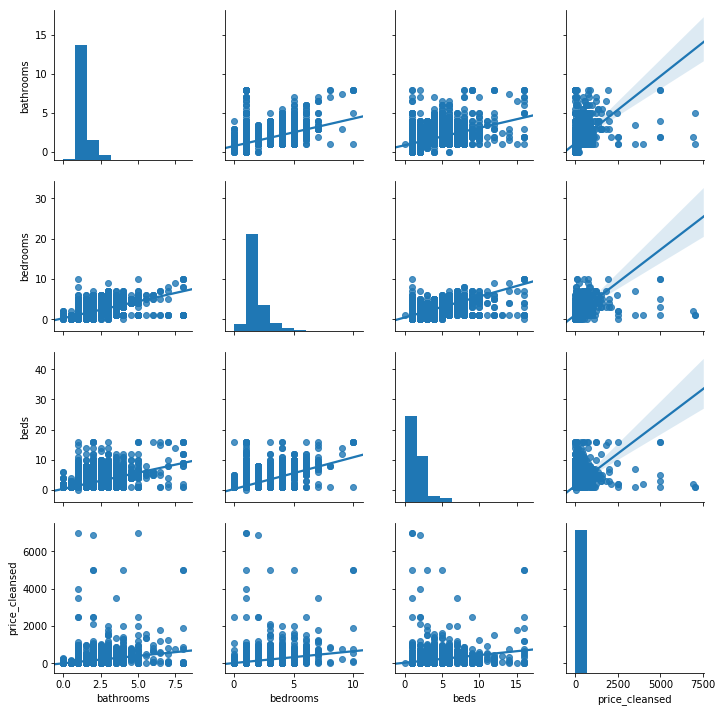

In [5]:
sns.pairplot(features, kind='reg');

To note:

- Canned correlation view
- Scales very different

In [6]:
features_sd = pd.DataFrame(preprocessing.scale(features),
                           index=features.index,
                           columns=features.columns)

In [7]:
features_sd.describe().loc[['mean', 'std'], :]

,bathrooms,bedrooms,beds,price_cleansed
mean,-1.447404e-16,9.348373e-17,3.611871e-17,-3.186945e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00


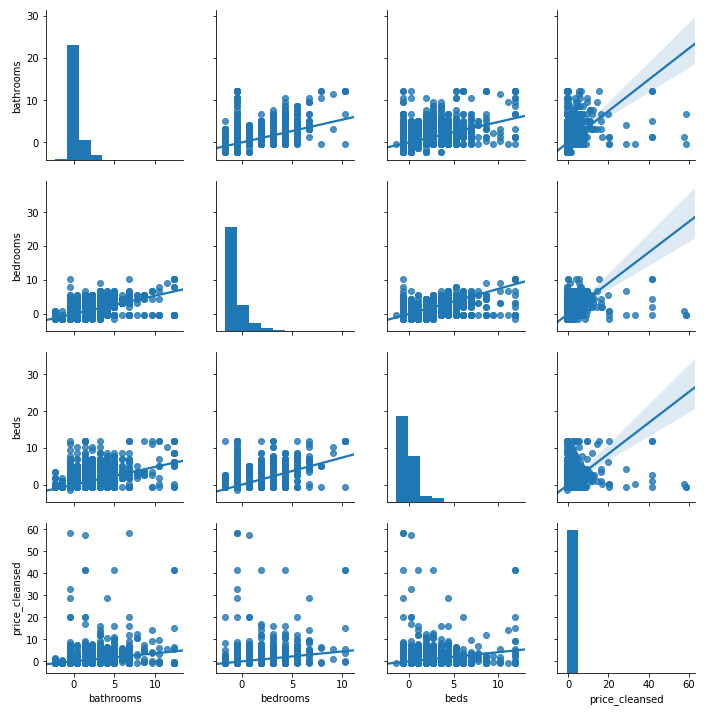

In [8]:
sns.pairplot(features_sd, kind='reg');

To note:

- Scaling removes mean and divides by the sd
- The method returns an array (what is an array?) so we need to build the `DataFrame` again

## Baseline of clustering house characteristics

In [9]:
km5 = cluster.KMeans(n_clusters=5)
km5

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

To note:

- Initialise instance without involving data

In [10]:
np.random.seed(1234)
k5cls = km5.fit(features_sd)

To note:

- Concept of seed and why we need it for reproducibility
- General `scikit-learn` pattern of `fit`

In [11]:
k5cls.labels_

array([0, 0, 0, ..., 3, 1, 0], dtype=int32)

To note:

- Concept of clustering solution
- Nature and importance of labels

**Exercise**

- Perform a classification with three and ten clusters instead
- Store the outputs separately (`k3cls` and `k10cls`, for example))

In [12]:
features.groupby(k5cls.labels_)\
        .size()

0    34953
1     6970
2       11
3     3357
4     8218
dtype: int64

To note:

- Comment variation on size
- Use of `groupby` with an external 1D array

In [13]:
features.groupby(k5cls.labels_)\
        .mean()\
        .T

,0,1,2,3,4
bathrooms,1.031056,2.088737,3.409091,2.443849,1.065101
bedrooms,0.933740,1.592826,3.818182,3.575216,2.037600
beds,1.159014,1.884792,5.000000,4.730712,2.662083
price_cleansed,66.064258,114.473171,5171.818182,283.366399,125.379898


To note:

- Meaning of `T`
- Too long and many of them based on 0/1. Meaningful?

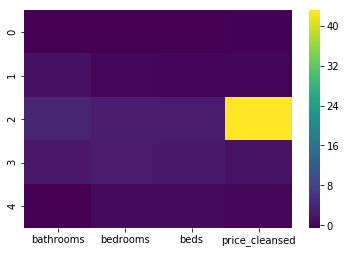

In [14]:
sns.heatmap(features_sd.groupby(k5cls.labels_)\
                    .mean(),
            cmap='viridis');

To note:

* Table looks at actual values (not the standardised ones used for clustering)
* The mean might be misleading if the distribution is not "well-behaved"
* Explore the entire distribution?

In [15]:
# Tidy up!
tidy = features_sd.stack()\
                  .reset_index()\
                  .rename(columns={'level_0': 'oid',
                                   'level_1': 'var',
                                   0: 'value'})\
                  .join(pd.Series(k5cls.labels_,
                                  name='cl_lab'),
                        on='oid')
tidy.head()

,oid,var,value,cl_lab
0,0,bathrooms,-0.480202,0.0
1,0,bedrooms,-0.421372,0.0
2,0,beds,-0.589993,0.0
3,0,price_cleansed,-0.620417,0.0
4,1,bathrooms,-0.480202,0.0


To note:

* Chain of actions (reproduce one by one separately)
* What does `stack` do?
* Why reset the index?
* How `rename` operates
* `join` in this case is not 1-to-1 but 1-to-many.
* For `join` to work, it needs to be indexed

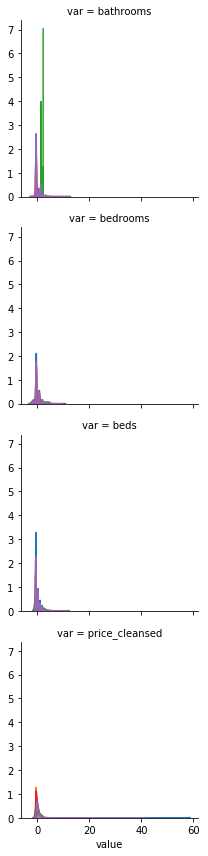

In [16]:
g = sns.FacetGrid(row='var', hue='cl_lab', data=tidy)
g.map(sns.kdeplot, 'value', shade=True)

To note:

* Scale problem in axes

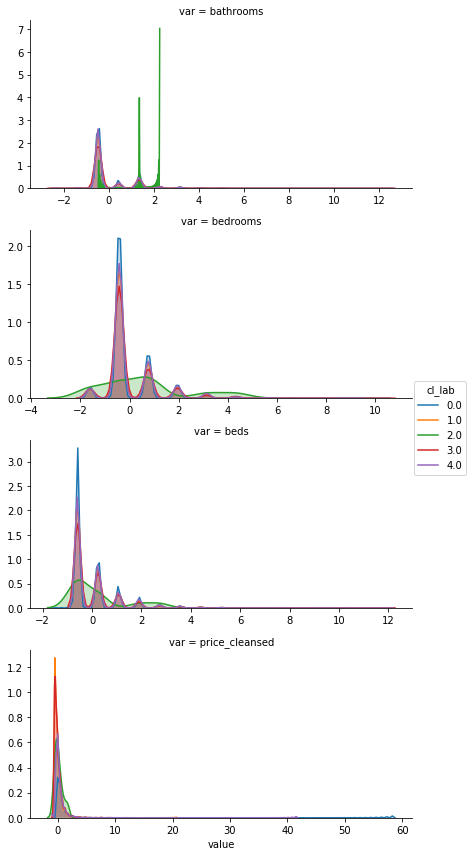

In [17]:
g = sns.FacetGrid(row='var', hue='cl_lab', data=tidy,
                  sharey=False, sharex=False, aspect=2)
g.map(sns.kdeplot, 'value', shade=True).add_legend();

To note:

- `sharex` and `sharey`
- What does `aspect` do? [Check help!]

/home/dani/anaconda/envs/gds/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


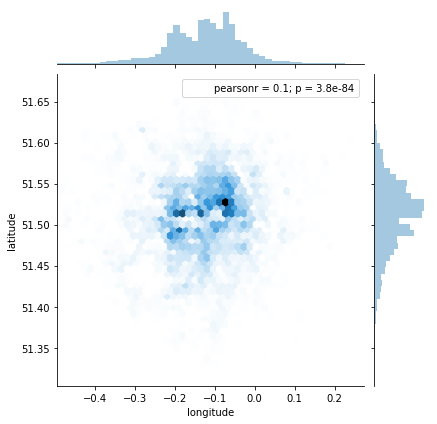

In [18]:
# Geographic distribution
cl0 = features.loc[k5cls.labels_==0, :]\
              .join(db.loc[:, ['longitude', 'latitude']])\
              .loc[:, ['longitude', 'latitude']]
sns.jointplot('longitude', 'latitude', data=cl0, kind='hex')

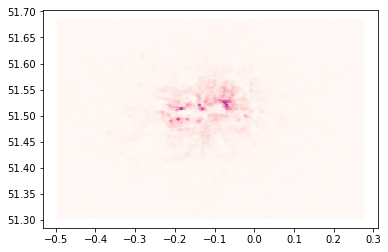

In [19]:
cl0 = features.loc[k5cls.labels_==0, :]\
              .join(db.loc[:, ['longitude', 'latitude']])\
              .loc[:, ['longitude', 'latitude']]
plt.hexbin(cl0['longitude'], cl0['latitude'], 
           cmap='RdPu', alpha=0.5);

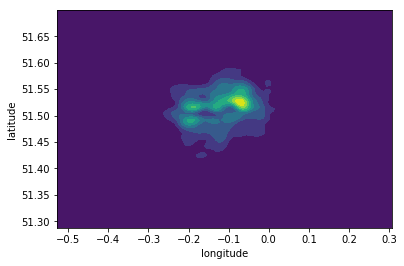

In [20]:
cl0 = features.loc[k5cls.labels_==0, :]\
              .join(db.loc[:, ['longitude', 'latitude']])\
              .loc[:, ['longitude', 'latitude']]
sns.kdeplot(cl0['longitude'], cl0['latitude'], 
            shade=True, cmap='viridis');

To note:

- Only works for a single cluster

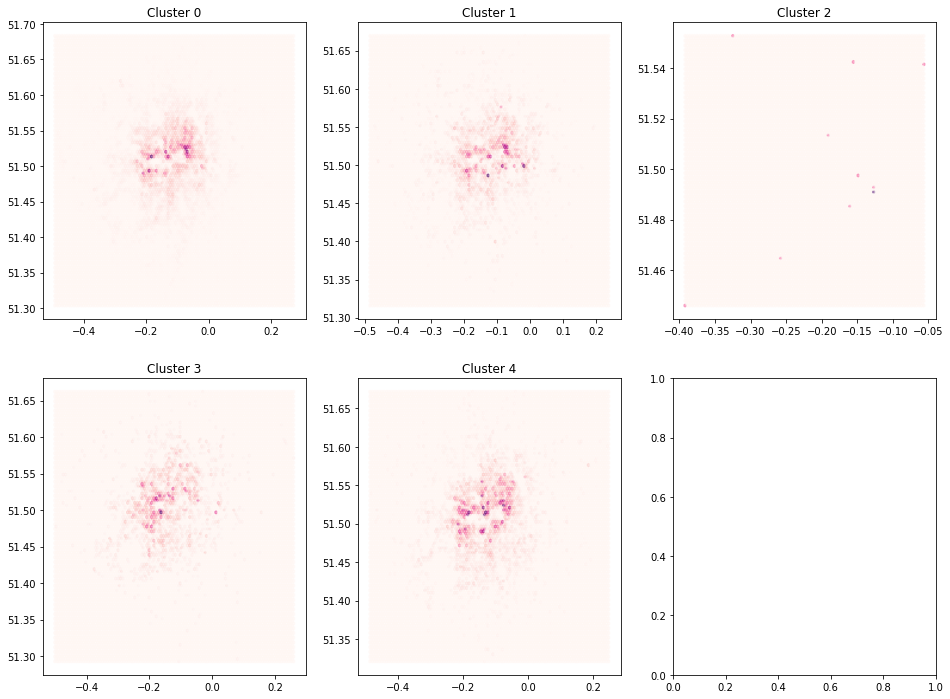

In [21]:
f, axs = plt.subplots(2, 3, figsize=(16, 12))
axs = axs.flatten()

for i in range(5):
    ax = axs[i]
    cl = features.loc[k5cls.labels_==i, :]\
                 .join(db.loc[:, ['longitude', 'latitude']])\
                 .loc[:, ['longitude', 'latitude']]
    ax.hexbin(cl['longitude'], cl['latitude'], 
               cmap='RdPu', alpha=0.5)
    ax.set_title('Cluster %i'%i)

To note:

- Operate on flattened axes
- Loop over an indicator
- Pull out an axis at a time
- Extract the coordinates of the properties in the cluster
- Pass coordinates to `hexbin`, which is run *on* `ax`
- Set the title

## Two-step clustering of house characteristics

To note:

- Mo dimensionality, mo problems
- Mixed data (continuous, binary)?

In [22]:
rt_dummies = pd.get_dummies(db['room_type'])
rt_dummies.head()

,Entire home/apt,Private room,Shared room
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [23]:
pt_dummies = pd.get_dummies(db['property_type'])
pt_dummies.head()

,Apartment,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Castle,Cave,Chalet,...,Lighthouse,Loft,Other,Parking Space,Ryokan (Japan),Serviced apartment,Tent,Townhouse,Villa,Yurt
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
features_xl = db[cont].join(rt_dummies)\
                      .join(pt_dummies)\
                      .dropna()

In [25]:
min_max_scaler = preprocessing.MinMaxScaler()
features_xl_sc = pd.DataFrame(min_max_scaler.fit_transform(features_xl),
                              index=features_xl.index,
                              columns=features_xl.columns)

To note:

- "Dummies" for categorical variables
- Rescaling everything to range [0, 1]

In [26]:
%time pca = PCA(n_components=2).fit_transform(features_xl_sc)

CPU times: user 732 ms, sys: 1.61 s, total: 2.34 s
Wall time: 404 ms


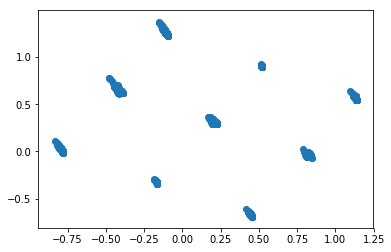

In [27]:
plt.scatter(pca[:, 0], pca[:, 1])

In [28]:
# k=9 as the plot above suggests
k_pca = cluster.KMeans(n_clusters=9).fit(pca)

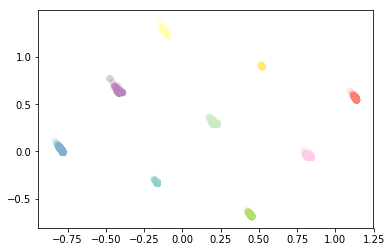

In [29]:
plt.scatter(pca[:, 0], pca[:, 1], 
            c=k_pca.labels_, cmap='Set3',
            alpha=0.1);

In [30]:
# k=5 as the original clustering
k_pca = cluster.KMeans(n_clusters=5).fit(pca)

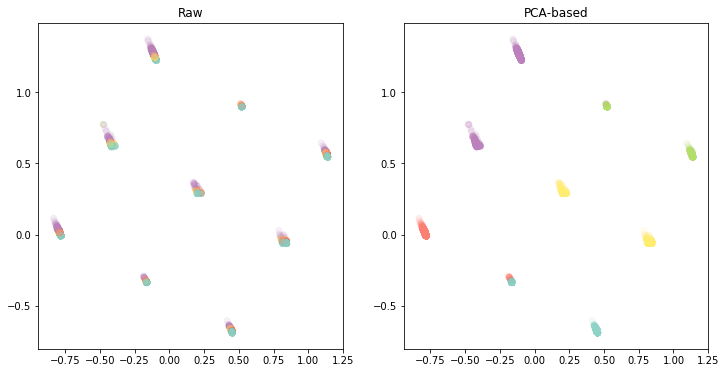

In [31]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(pca[:, 0], pca[:, 1], 
            c=k5cls.labels_, cmap='Set3',
            alpha=0.1);
axs[0].set_title('Raw')

axs[1].scatter(pca[:, 0], pca[:, 1], 
            c=k_pca.labels_, cmap='Set3',
            alpha=0.1);
axs[1].set_title('PCA-based')

plt.show()

## Comparing solutions

Calinski-Harabaz score: ratio of between and within dispersion.

[[`scikit-learn` Explanation]](http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index)

In [32]:
chs_raw = metrics.calinski_harabaz_score(features_sd, k5cls.labels_)
chs_pca = metrics.calinski_harabaz_score(features_xl_sc, k_pca.labels_)

pd.Series({'0-CHS-Raw': chs_raw,
           '1-CHS-PCA': chs_pca})

0-CHS-Raw     26712.841744
1-CHS-PCA    141509.670699
dtype: float64

To note:

* Higher CHS, between dispersion is larger than within dispersion, better result (for the transformed data).
* When using the original data, performance flips.

**Exercise**

- Perform a similar clustering exercise using the `review_scores` features
- Explore differences in the key groups
- Explore the spatial distribution of each group
- **[PRO]**Can you compare both solutions? To what extent do they share observations?